In [6]:
import os  # Import os to use funtion and to work with environment variables
import tensorflow as tf # deep learning framework

os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED' # use to load model from tensorflow hub in compressed format [COMPRESSED/UNCOMPRESSED]

In [7]:
import IPython.display as display # display images, video
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl # use to add pltting, lines and labels for images,graph

mpl.rcParams['figure.figsize']  = (12, 12) # modify plotting setting
mpl.rcParams['axes.grid'] = False # disables the grid in plots

import numpy as np # for mathematical computation and array operations
import PIL.Image # this library use to open,save and save file format
import time # measure the execution time
import functools

In [8]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8) #convert tensor into numpy array and store it in 8 bit integer
  if np.ndim(tensor)>3: # check if tensor has 3 dimensions (height,width,channels) and take 1 image to work
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor) # convert numpy array into PIL image

In [9]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

# I have uploaded my images in .jpg on drive and give access to anyone can see the images using the link but it shows error. It shows error that 'unknown image file format.One of jpeg,png,gif,bmp required.'
# so i uploaded images on notebook as temporary file
#content_path = tf.keras.utils.get_file('9.jpg', 'https://drive.google.com/file/d/1MyCm7yhuNDJEdqy2ucQPOn5vwuoWErAE/uc?export=download')
#style_path = tf.keras.utils.get_file('10.jpg', 'https://drive.google.com/file/d/1E47-13dmRSWV0_2sl6wr3dk-4oN-FbRo/uc?export=download')

83281/83281 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step
195196/195196 ━━━━━━━━━━━━━━━━━━━━ 1s 3us/step


In [10]:
def load_img(path_to_img): # set maximum size of the image,read and decode the image,convert pixel to float 32
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32) #use to resize the image
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [11]:
import matplotlib.pyplot as plt

def imshow(image, title=None): # use to show am image and checks image is not more than 3 dimentions, if it is, then squeeze() is used to remove the batch dimention
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

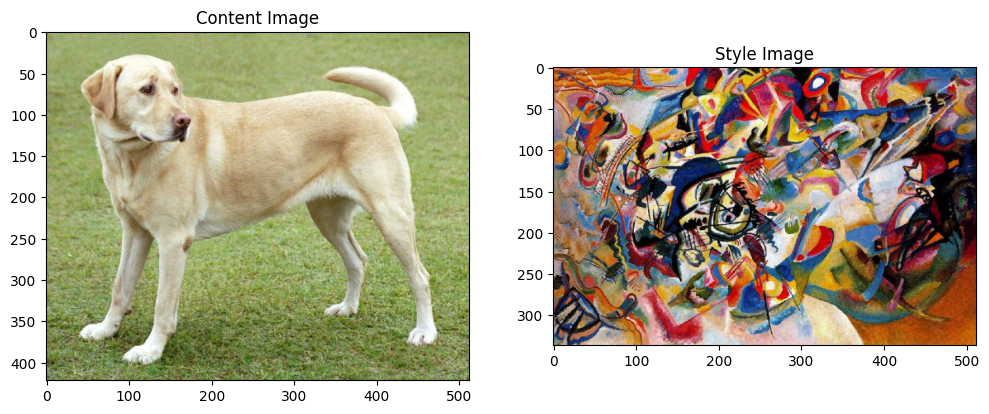

In [12]:
#content_image = '/content/dora.jpeg'
#style_image = '/content/s1.jpeg'

content_image = load_img(content_path) # loads the content and style image and create a subplot to display the images
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, "Content Image")

plt.subplot(1, 2, 2)
imshow(style_image, "Style Image")
plt.show()

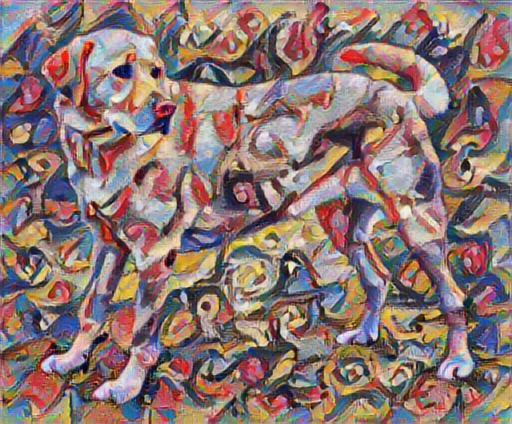

In [13]:
import tensorflow_hub as hub # it allows to use pretrained models
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2') # load the arbitrary-image-stylization-v1 model
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]# take content and style images as an input and retun a style image
tensor_to_image(stylized_image)

In [14]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255) # load the VGG19 model and take a content image as an input and convert from RGB to BGR and set pixel value(between 0 and 255)
x = tf.image.resize(x, (224, 224)) #resize the image
vgg = tf.keras.applications.VGG19(include_top=True,
                                  weights='imagenet',
                                  input_tensor=None,
                                  input_shape=None,
                                  pooling=None,
                                  classes=1000,
                                  classifier_activation="softmax",
                                  name="vgg19",) #pass the arguments in VGG19 model
prediction_probabilities = vgg(x) # use to get prediction probabilities
prediction_probabilities.shape

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


TensorShape([1, 1000])

In [15]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0] # converts into numpy arrany and decode the predictions from predefined imagenet
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


[('Labrador_retriever', np.float32(0.49317107)),
 ('golden_retriever', np.float32(0.23665293)),
 ('kuvasz', np.float32(0.03635751)),
 ('Chesapeake_Bay_retriever', np.float32(0.024182767)),
 ('Greater_Swiss_Mountain_dog', np.float32(0.018646102))]

In [16]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet') # it does not include fully connected layer

print()
for layer in vgg.layers: # this loop prints name of the layer
  print(layer.name)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [17]:
content_layers = ['block5_conv2'] # select one deep convolution layer

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'] # select 5 different layers

num_content_layers = len(content_layers) # to count the layers added in the variable
num_style_layers = len(style_layers)

In [18]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False # during training phase weights will not change

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [19]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape) # print highest, lowerst and average values
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_48']
Received: inputs=Tensor(shape=(1, 336, 512, 3))
  warnings.warn(msg)


block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



In [20]:
def gram_matrix(input_tensor): # calculate a Gram matrix
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [21]:
class StyleContentModel(tf.keras.models.Model): # create a custom model and define constructor that take two inputs and return the output from layers
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs): #
    "Expects float input in [0,1]" # convert image to 0 to 255, pass the preprocessed_input to VGG19 model
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], #divide the output in style layers and content layers
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output) #calculate a gram matrix
                     for style_output in style_outputs]

    content_dict = {content_name: value # this dictionary saves content name and content output
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value # this dictionary saves style name and style output
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict} #return both dictionaries

In [22]:
extractor = StyleContentModel(style_layers, content_layers) #extract the style and content layers and send content image to VGG19 and print content and style layers in sequence with shape,min, max, mean value

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_70']
Received: inputs=Tensor(shape=(1, 422, 512, 3))
  warnings.warn(msg)


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.005522845
    max:  28014.555
    mean:  263.79022

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.484
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.976

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320502.0
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.37
    mean:  1487.0378

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764149


In [23]:
style_targets = extractor(style_image)['style'] #use to extract style and content image
content_targets = extractor(content_image)['content']

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_70']
Received: inputs=Tensor(shape=(1, 336, 512, 3))
  warnings.warn(msg)


In [24]:
image = tf.Variable(content_image) #creating a variable that represent value can be changed

In [25]:
def clip_0_1(image): # use to keep the values between 0 and 1
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [26]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1) #implements adam optimizer

In [27]:
style_weight=1e-2
content_weight=1e4

In [28]:
def style_content_loss(outputs): #extract style and content images and add losses and optimizer will minimize the losses
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [29]:
@tf.function() # it will compile the function
def train_step(image): # current image is passed to the function and gradients math function helps to improve the image
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

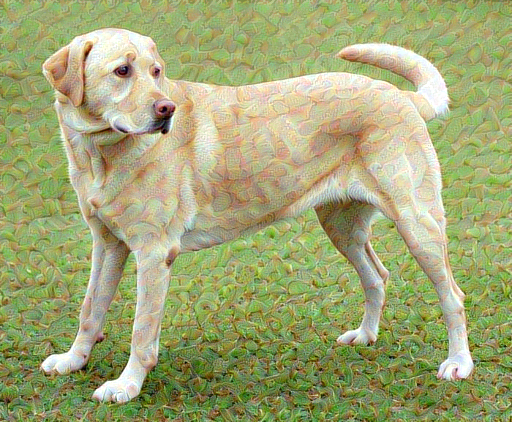

In [30]:
train_step(image) # it runs 3 times and convert this image into real image
train_step(image)
train_step(image)
tensor_to_image(image)

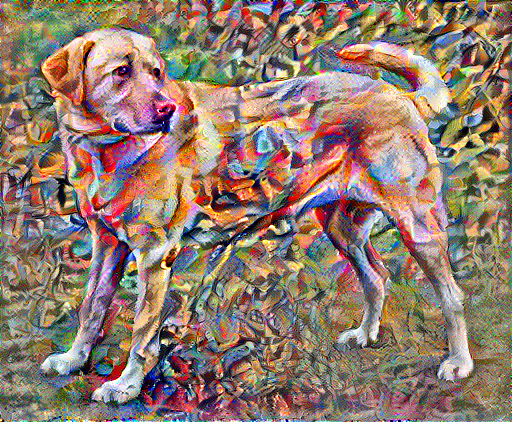

Train step: 1000
Total time: 78.9


In [31]:
import time # import timer
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step)) #take the image 10x100 times, update it and print execution time

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [32]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

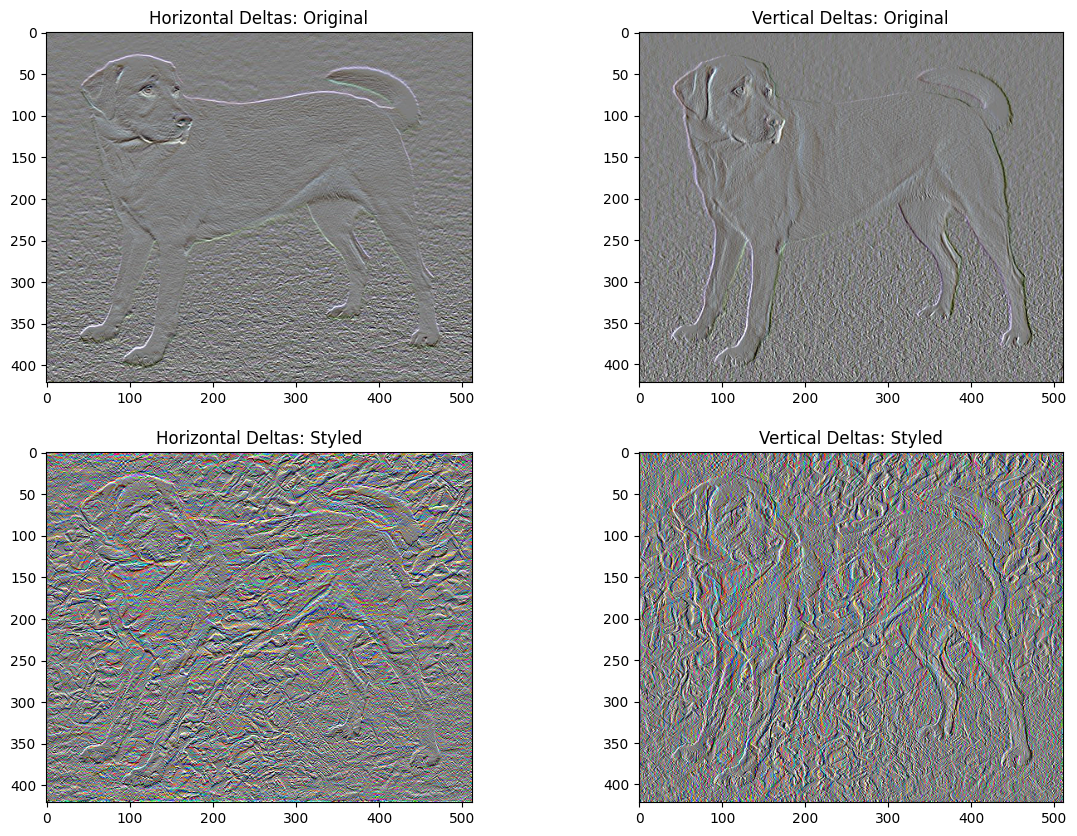

In [33]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3) # it shows the changes
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4) # it shows the changes
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

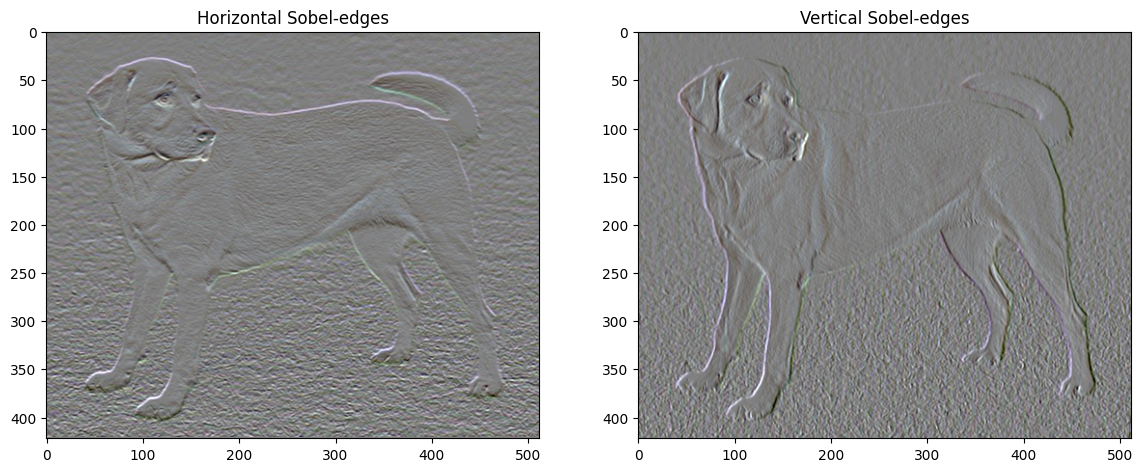

In [34]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [35]:
def total_variation_loss(image): # compute the total variation loss
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [36]:
total_variation_loss(image).numpy()

np.float32(149408.28)

In [37]:
tf.image.total_variation(image).numpy() #compute total variation and convert into numpy

array([149408.28], dtype=float32)

In [38]:
total_variation_weight=30

In [39]:
@tf.function()
def train_step(image): #extract the images and count losses, use optimizer to apply changes
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [40]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1) #adam optimizer is used to update the image
image = tf.Variable(content_image)

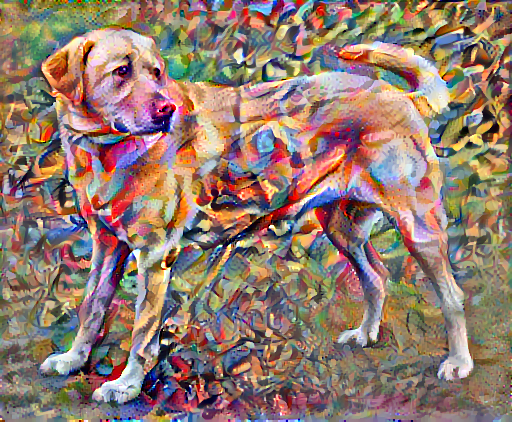

Train step: 1000
Total time: 83.1


In [41]:
import time # train the image 1000 times and blend the style image with content image
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [42]:
file_name = 'stylized-image.png' # it saves the image as .png formate and download the image into local computer
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
  files.download(file_name)
except (ImportError, AttributeError):
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
!nvidia-smi

Sun Apr  6 15:46:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             33W /   70W |    7800MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----